### Imports

In [1]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
# import download
from random import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
import sys
import h5py

### RGBFlow Transformer

In [3]:
class HDF5DatasetRGBFlow(tf.keras.utils.Sequence):
    def __init__(self, data_dir1, data_dir2, batch_size=32):
        self.data_dir1 = data_dir1
        self.data_dir2 = data_dir2
        self.batch_size = batch_size
        self.file_list = [file for file in os.listdir(data_dir1) if file.endswith('.h5')]
        self.num_samples = len(self.file_list)

    def __len__(self):
        return self.num_samples // self.batch_size

    def __getitem__(self, index):
        batch_files = self.file_list[index * self.batch_size: (index + 1) * self.batch_size]

        batch_inputs = []
        batch_targets = []

        for file_name in batch_files:
            file_path1 = os.path.join(self.data_dir1, file_name)
            file_path2 = os.path.join(self.data_dir2, file_name)
            temp = []
            with h5py.File(file_path1, 'r') as hf:
                # Load data and label from HDF5 file
                input_data1 = hf['data'][:]  
                
                target_data1 = hf['labels'][:]  
                
                temp.append(input_data1)
                
                with h5py.File(file_path2, 'r') as f:
                # Load data and label from HDF5 file
                    input_data2 = f['data'][:]  
                    target_data2 = f['labels'][:]  
                    temp.append(input_data2)
                batch_inputs.append(np.array(temp))
                batch_targets.append(target_data1)

        return tf.convert_to_tensor(batch_inputs), tf.convert_to_tensor(batch_targets)

data_directory_train = 'filedata/train'  
data_directory_valid = 'filedata/valid'
data_directory_test = 'filedata/test'
data_directory_train_flow = 'filedata/train1'  
data_directory_valid_flow = 'filedata/valid1'
data_directory_test_flow = 'filedata/test1'

batch_size = 32
train_loader = HDF5DatasetRGBFlow(data_directory_train, data_directory_train_flow, batch_size=batch_size)
valid_loader = HDF5DatasetRGBFlow(data_directory_valid, data_directory_valid_flow, batch_size=batch_size)
test_loader = HDF5DatasetRGBFlow(data_directory_test, data_directory_test_flow, batch_size=batch_size)

In [4]:
from keras import backend as K 
BATCH_SIZE = 240               
AUTO = tf.data.AUTOTUNE             
INPUT_SHAPE = (2, 20, 14, 14, 512)      
NUM_CLASSES = 2                      

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 20

# TUBELET EMBEDDING
PATCH_SIZE = (4, 2, 2)                # Patch size to divide input of size (20, 14, 14) i.e., (Frames * Transfer_Img_Size * Transfer_Img_Size)
NUM_PATCHES = (INPUT_SHAPE[1] // PATCH_SIZE[0]) ** 2 
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 8

In [5]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

In [6]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

In [11]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    
    inputs = layers.Input(shape=input_shape)
    reshaped_inputs = tf.reshape(inputs, (32, 40, 14, 14, 512))
    input1, input2 = tf.split(reshaped_inputs, num_or_size_splits=2, axis=1)
    print(inputs.shape, input1.shape, input2.shape)
    
    patches1 = tubelet_embedder(input1)
    encoded_patches1 = positional_encoder(patches1)

    for _ in range(transformer_layers):
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(encoded_patches1, encoded_patches1)
        x2 = layers.Add()([attention_output, encoded_patches1])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        encoded_patches1 = x3

    representation1 = encoded_patches1
    patches2 = tubelet_embedder(input2)
    encoded_patches2 = positional_encoder(patches2)

    for _ in range(transformer_layers):
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(encoded_patches2, encoded_patches2)
        x2 = layers.Add()([attention_output, encoded_patches2])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)
        encoded_patches2 = x3
    
    representation2 = layers.Dense(embed_dim, activation=tf.nn.gelu)(encoded_patches2)
    
    representation = layers.Add()([representation1, representation2])
    
    attention_representation = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
    )(representation, representation)
    
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(attention_representation)
    
    representation = layers.GlobalAvgPool1D()(representation)

    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)
    print(outputs.shape)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
def run_experiment():
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
    )
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy'
        ],
    )

    model2 = model.fit(train_loader, epochs=20, validation_data=valid_loader)
    return model, model2

model, history = run_experiment()

(None, 2, 20, 14, 14, 512) (32, 20, 14, 14, 512) (32, 20, 14, 14, 512)
(32, 2)
Epoch 1/20
22/22 [==============================] - 540s 22s/step - loss: 0.7650 - accuracy: 0.6435 - val_loss: 0.3877 - val_accuracy: 0.8906
Epoch 2/20
22/22 [==============================] - 464s 20s/step - loss: 0.3165 - accuracy: 0.8991 - val_loss: 0.2289 - val_accuracy: 0.8906
Epoch 3/20
22/22 [==============================] - 478s 21s/step - loss: 0.2067 - accuracy: 0.9247 - val_loss: 0.1258 - val_accuracy: 0.9531
Epoch 4/20
22/22 [==============================] - 492s 22s/step - loss: 0.1397 - accuracy: 0.9588 - val_loss: 0.0987 - val_accuracy: 0.9844
Epoch 5/20
22/22 [==============================] - 451s 20s/step - loss: 0.1277 - accuracy: 0.9602 - val_loss: 0.1308 - val_accuracy: 0.9531
Epoch 6/20
22/22 [==============================] - 439s 19s/step - loss: 0.0832 - accuracy: 0.9688 - val_loss: 0.0928 - val_accuracy: 0.9688
Epoch 7/20
22/22 [==============================] - 462s 20s/step - l

In [13]:
result = model.evaluate(test_loader)

6/6 [==============================] - 117s 19s/step - loss: 0.4006 - accuracy: 0.9479


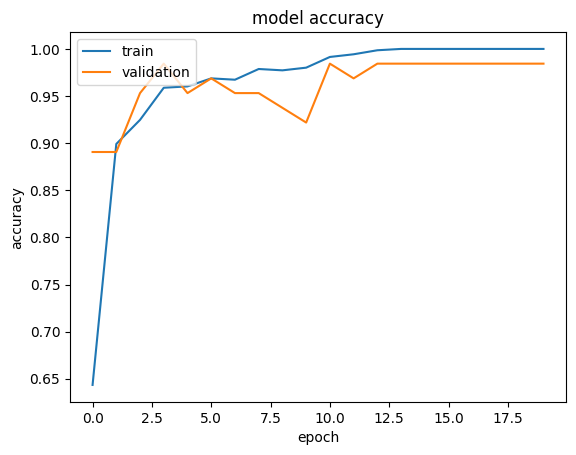

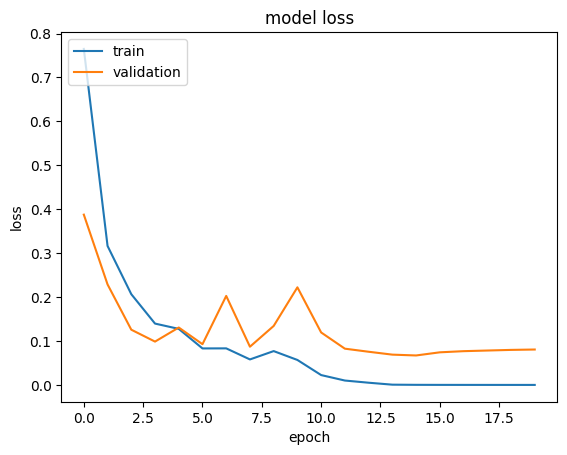

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()